In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pdb


from scm_module import *
from mixture_solver import *

# Job Runner (node, graph, intv-loc, cov-strength, mean perturb)

In [4]:
args={}

#Variations in the input params
node_list = [8]
max_strength=10
num_parents=2 #num_nodes-1 # 2 initially
run_list = [0,1,2]
new_noise_mean_list=[10] #np.linspace(5,10,5).tolist()
sample_list=[100,800,1600,3200,6400,12800,25600]


all_node_run_dict = {}
for num_nodes in node_list:
    print("========================")
    print("Num Node:",num_nodes)
    print("========================")
    
    #If we want to intervene on all the nodes (ZERO INDEXED)
    intv_targets = list(range(num_nodes))
    #If we want to intervene on only certain nodes
#     intv_targets = [(0+num_nodes)//2,] #(ZERO INDEXED)
    
    all_run_dict = {}
    for ridx in run_list:
        print("\t run_idx:",ridx)
        alpha_list=[5]  #np.linspace(0,max_strength,3).tolist()
        alpha_mean_error_dict={}
        for aidx,alpha in enumerate(alpha_list):
            print("\t\t alpha:",alpha)
            
            #Creating the SCM
            args["noise_mean_list"]=[5.0,]*num_nodes
            args["noise_sigma_list"]=[1.0,]*num_nodes
            scmGen = RandomSCMGenerator(num_nodes=num_nodes,
                                          max_strength=alpha,
                                          num_parents=num_parents,
            )
            gSCM = scmGen.generate_gaussian_scm(scm_args=args)
            
            #Running over different purturbed mean to run the experiment
            mean_error_dict={}
            for new_noise_mean in new_noise_mean_list:
                error_list = []
                for samples in sample_list:
                    print("\t\t\t sample:",samples) 
                    #Generating the samples and interventions configs
                    intv_args_dict,mixture_samples = gSCM.generate_gaussian_mixture(intv_targets,
                                                                                    new_noise_mean,
                                                                                    samples)
    
                    #Running the disentanglement
                    gSolver = GaussianMixtureSolver()
                    err,_ = gSolver.mixture_disentangler(intv_args_dict,mixture_samples)
                    error_list.append(err)
                #Collecting error for each sample
                mean_error_dict[str(new_noise_mean)]=error_list
            #Collecting error for each new max strength
            alpha_mean_error_dict["{:.2f}".format(alpha)]=mean_error_dict
        #Collecting all the runs
        all_run_dict[ridx]=alpha_mean_error_dict
    all_node_run_dict[num_nodes]=all_run_dict

#Next consolidate all the runs in single place

Num Node: 8
	 run_idx: 0
		 alpha: 5


KeyboardInterrupt: 

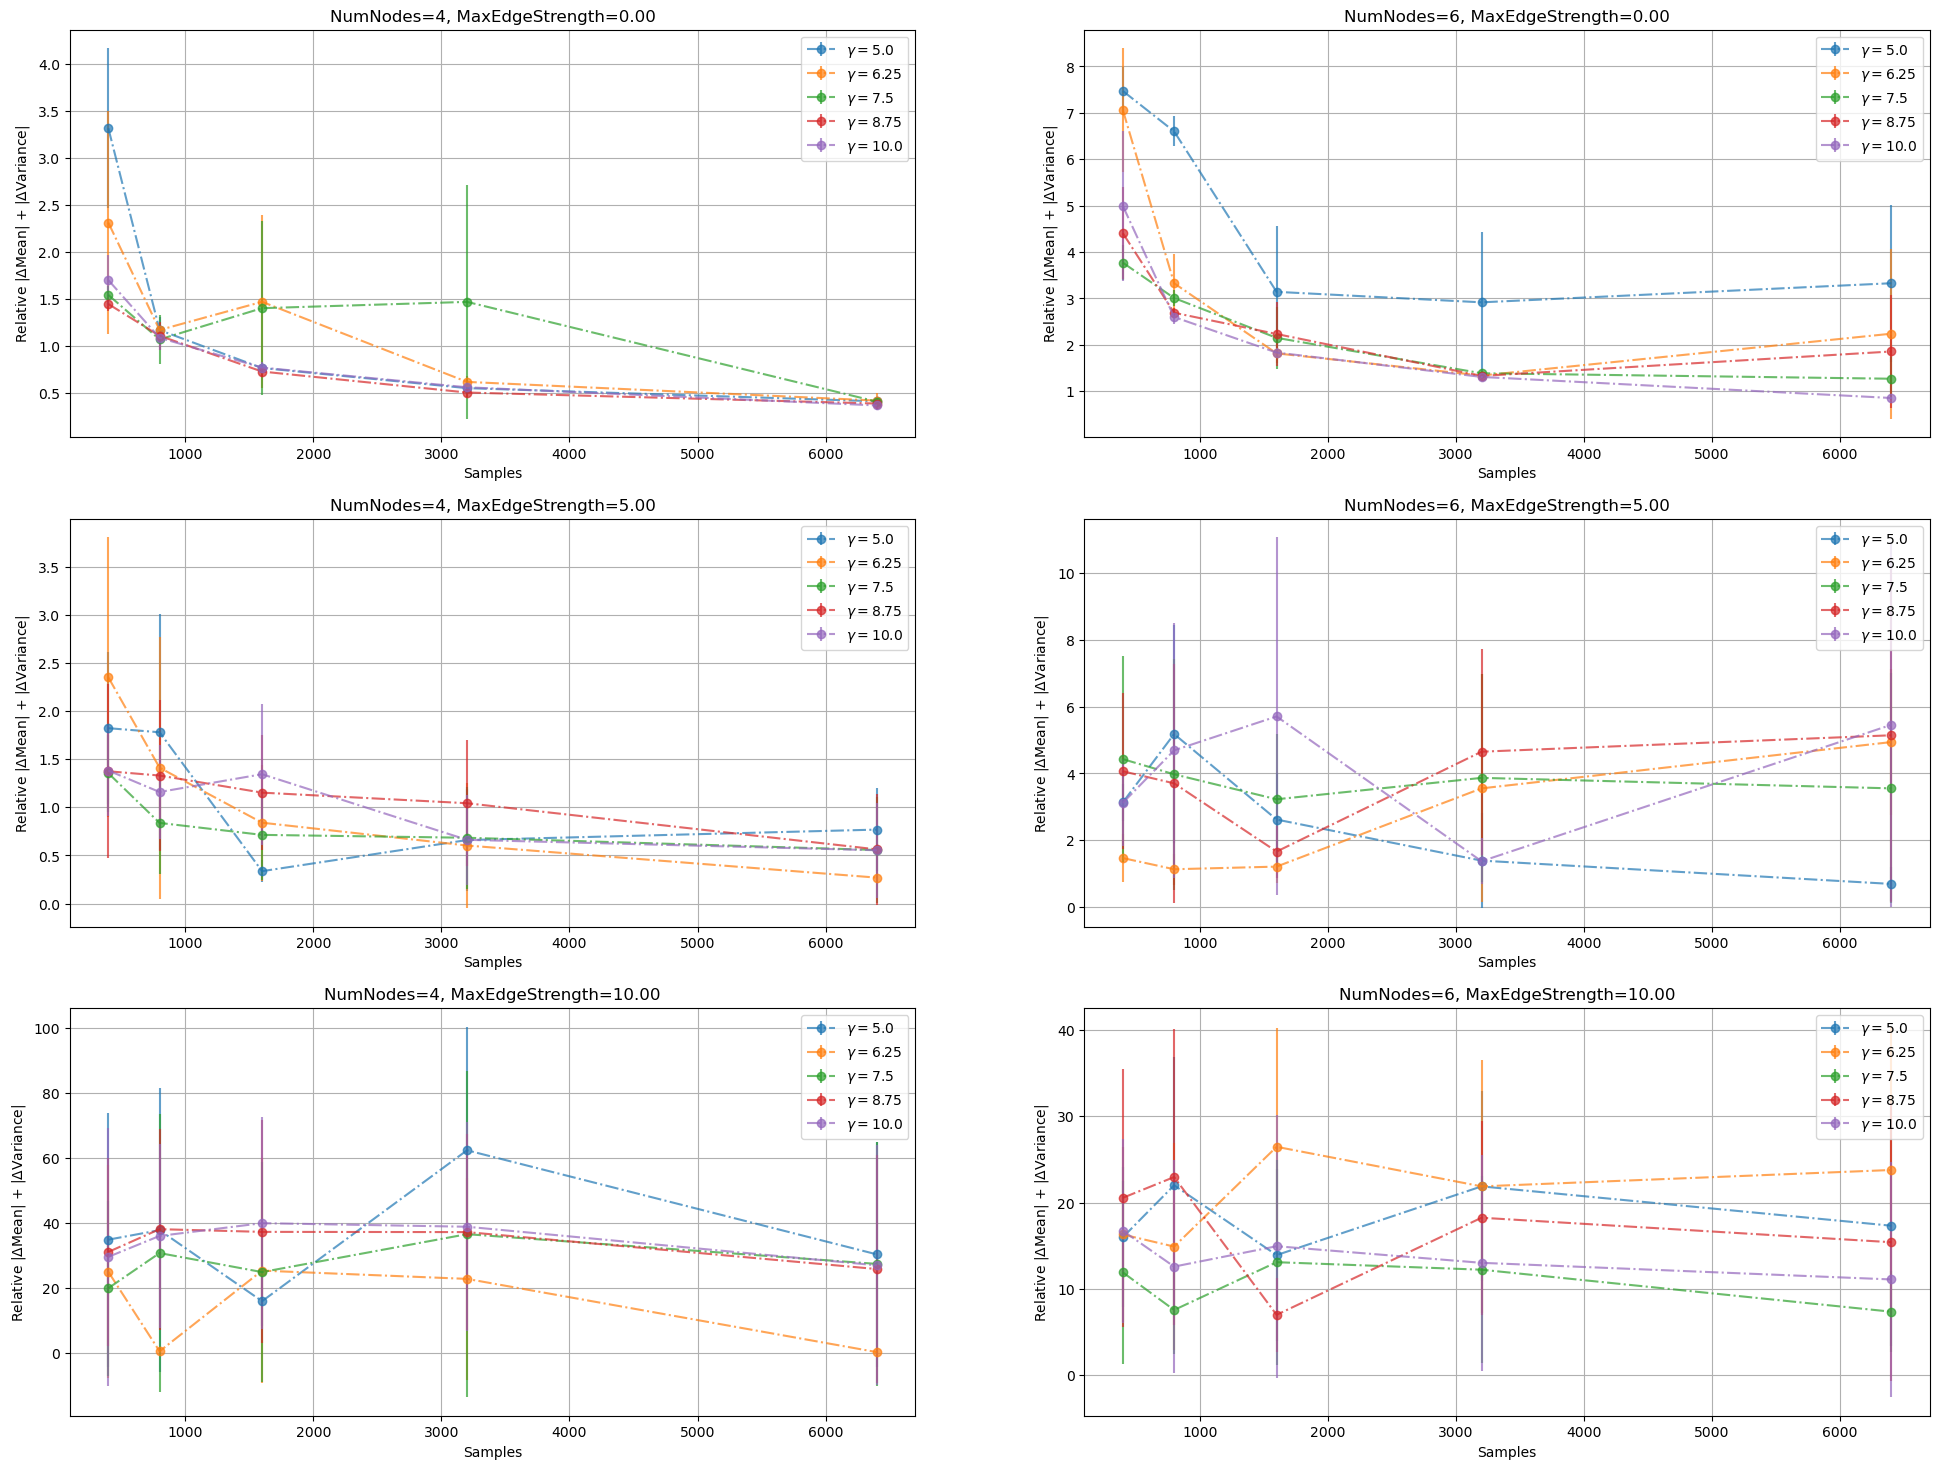

In [3]:
'''
run_list
alpha_list
sample_list
new_noise_mean_list
'''

#Consolidating the errors into into one plot
plt.rcParams['figure.figsize'] = [24, 6*len(alpha_list)]
fig,ax = plt.subplots(nrows=len(alpha_list),ncols=len(node_list))

for nidx,num_nodes in enumerate(node_list):
    all_run_dict = all_node_run_dict[num_nodes]
    for aidx,alpha in enumerate(all_run_dict[run_list[0]].keys()):
        for mean in all_run_dict[run_list[0]][alpha].keys():
            #Getting the average for all the runs
            all_run_mat = []
            for ridx in run_list:
                all_run_mat.append(all_run_dict[ridx][alpha][mean])
            #Getting the mean and variance
            sample_arr = np.array(sample_list)[2:]
            all_run_mat = np.array(all_run_mat)[:,2:]
            alpha_mean_error_mean = np.mean(all_run_mat,axis=0)
            alpha_mean_error_std = np.std(all_run_mat,axis=0)

            #Now we will plot for this config
            ax[aidx,nidx].errorbar(sample_arr,alpha_mean_error_mean,alpha_mean_error_std,label="$\gamma=${}".format(mean),ls="-.",marker="o",alpha=0.7)
    #         ax[aidx].fill_between(sample_list,
    #                               alpha_mean_error_mean-alpha_mean_error_std,
    #                               alpha_mean_error_mean+alpha_mean_error_std,
    #                               alpha=0.1
    #                              )
        ax[aidx,nidx].set_xlabel("Samples")
        ax[aidx,nidx].set_ylabel("Relative |$\Delta$Mean| + |$\Delta$Variance|")
        ax[aidx,nidx].grid()
        ax[aidx,nidx].legend()
        ax[aidx,nidx].set_title("NumNodes={}, MaxEdgeStrength={}".format(str(num_nodes),str(alpha)))
fig.savefig('all_nodes_combined_one_intv_sparse_graph.png'.format(num_nodes), dpi=fig.dpi)

# Rescaling a particular row (one fixed intv target)

In [152]:
args={}

num_nodes=6
max_strength=10
num_parents=num_nodes-1 # 2 initially
run_list = [0,1,2]

intv_loc_list=list(range(1,num_nodes))
all_run_dict = {}
for ridx in run_list:
#     print("\n\n\n\n\n\n\n\n\n\n\n\n\n\n")
    print("run_idx:",ridx)
    intv_loc_error_dict={}
    for intv_loc in intv_loc_list:
        print("\t interv_loc:",intv_loc)
        #If we want to intervene on all the nodes (ZERO INDEXED)
        # intv_targets = list(range(num_nodes))
        #If we want to intervene on only certain nodes
        intv_targets = [intv_loc,] #(ZERO INDEXED)

        args["noise_mean_list"]=[5.0,]*num_nodes
        args["noise_sigma_list"]=[1.0,]*num_nodes
        base_adj_mat = generate_random_graph(num_nodes=num_nodes,
                                              max_strength=max_strength,
                                              num_parents=num_parents,
        )
#         print(base_adj_mat)
        #Now we will rescale the intervened row
        alpha_error_dict={}
        alpha_list = np.linspace(0,5,5)#[0,1,2,4,8] #This scale might be too much, maybe see btween 0 and 1
        for aidx,alpha in enumerate(alpha_list):
#             print("\n\n\n\n\n\n\n\n\n\n\n\n\n\n")
            print("\t\t alpha:",alpha)
            adj_mat = base_adj_mat.copy()
            adj_mat[intv_loc,:]=alpha*adj_mat[intv_loc,:]
#             print(adj_mat)
            
            #Creating the SCM
            args["adj_mat"]=adj_mat
            args["debug_mode"]=False
            gSCM = GaussianSCM(args)
            
            #Setting the intervention params
            new_noise_mean = 1.0
            sample_list=[10,20,40,100,150,200,400,800,1600,3200,6400]
            sample_error_list=[]
            for samples in sample_list:
                #print("\t\t\t sample:",samples)
                err,_ = expt_runner(gSCM,samples,num_nodes,new_noise_mean,intv_targets,debug=args["debug_mode"])
                sample_error_list.append(err)
                #pdb.set_trace()

            #Plotting the error
            alpha_error_dict[alpha]=sample_error_list
        intv_loc_error_dict[intv_loc]=alpha_error_dict
    all_run_dict[ridx]=intv_loc_error_dict

run_idx: 0
	 interv_loc: 1
		 alpha: 0.0
		 alpha: 1.25
		 alpha: 2.5
		 alpha: 3.75
		 alpha: 5.0
	 interv_loc: 2
		 alpha: 0.0
		 alpha: 1.25
		 alpha: 2.5
		 alpha: 3.75
		 alpha: 5.0
	 interv_loc: 3
		 alpha: 0.0
		 alpha: 1.25
		 alpha: 2.5
		 alpha: 3.75
		 alpha: 5.0
	 interv_loc: 4
		 alpha: 0.0
		 alpha: 1.25
		 alpha: 2.5
		 alpha: 3.75
		 alpha: 5.0
	 interv_loc: 5
		 alpha: 0.0
		 alpha: 1.25
		 alpha: 2.5
		 alpha: 3.75
		 alpha: 5.0
run_idx: 1
	 interv_loc: 1
		 alpha: 0.0
		 alpha: 1.25
		 alpha: 2.5
		 alpha: 3.75
		 alpha: 5.0
	 interv_loc: 2
		 alpha: 0.0
		 alpha: 1.25
		 alpha: 2.5
		 alpha: 3.75
		 alpha: 5.0
	 interv_loc: 3
		 alpha: 0.0
		 alpha: 1.25
		 alpha: 2.5
		 alpha: 3.75
		 alpha: 5.0
	 interv_loc: 4
		 alpha: 0.0
		 alpha: 1.25
		 alpha: 2.5
		 alpha: 3.75
		 alpha: 5.0
	 interv_loc: 5
		 alpha: 0.0
		 alpha: 1.25
		 alpha: 2.5
		 alpha: 3.75
		 alpha: 5.0
run_idx: 2
	 interv_loc: 1
		 alpha: 0.0
		 alpha: 1.25
		 alpha: 2.5
		 alpha: 3.75
		 alpha: 5.0

# Interveneing on all the nodes

In [149]:
args={}

num_nodes=4
max_strength=10
num_parents=num_nodes-1 # 2 initially
run_list = [0,1,2]

intv_loc_list=[1]#list(range(1,num_nodes))
all_run_dict = {}
for ridx in run_list:
#     print("\n\n\n\n\n\n\n\n\n\n\n\n\n\n")
    print("run_idx:",ridx)
    intv_loc_error_dict={}
    for intv_loc in intv_loc_list:
        print("\t interv_loc:",intv_loc)
        #If we want to intervene on all the nodes (ZERO INDEXED)
        intv_targets = list(range(num_nodes))
        #If we want to intervene on only certain nodes
#         intv_targets = [intv_loc,] #(ZERO INDEXED)

        args["noise_mean_list"]=[5.0,]*num_nodes
        args["noise_sigma_list"]=[1.0,]*num_nodes
        base_adj_mat = generate_random_graph(num_nodes=num_nodes,
                                              max_strength=max_strength,
                                              num_parents=num_parents,
        )
#         print(base_adj_mat)
        #Now we will rescale the intervened row
        alpha_error_dict={}
        alpha_list = np.linspace(0,5,5)#[0,1,2,4,8] #This scale might be too much, maybe see btween 0 and 1
        for aidx,alpha in enumerate(alpha_list):
#             print("\n\n\n\n\n\n\n\n\n\n\n\n\n\n")
            print("\t\t alpha:",alpha)
            adj_mat = base_adj_mat.copy()
            adj_mat=alpha*adj_mat
#             print(adj_mat)
            
            #Creating the SCM
            args["adj_mat"]=adj_mat
            args["debug_mode"]=False
            gSCM = GaussianSCM(args)
            
            #Setting the intervention params
            new_noise_mean = 1.0
            sample_list=[10,20,40,100,150,200,400,800,1600,3200]
            sample_error_list=[]
            for samples in sample_list:
                #print("\t\t\t sample:",samples)
                err,_ = expt_runner(gSCM,samples,num_nodes,new_noise_mean,intv_targets,debug=args["debug_mode"])
                sample_error_list.append(err)
                #pdb.set_trace()

            #Plotting the error
            alpha_error_dict[alpha]=sample_error_list
        intv_loc_error_dict[intv_loc]=alpha_error_dict
    all_run_dict[ridx]=intv_loc_error_dict

run_idx: 0
	 interv_loc: 1
		 alpha: 0.0
		 alpha: 1.25
		 alpha: 2.5
		 alpha: 3.75
		 alpha: 5.0
run_idx: 1
	 interv_loc: 1
		 alpha: 0.0
		 alpha: 1.25
		 alpha: 2.5
		 alpha: 3.75
		 alpha: 5.0
run_idx: 2
	 interv_loc: 1
		 alpha: 0.0
		 alpha: 1.25
		 alpha: 2.5
		 alpha: 3.75
		 alpha: 5.0


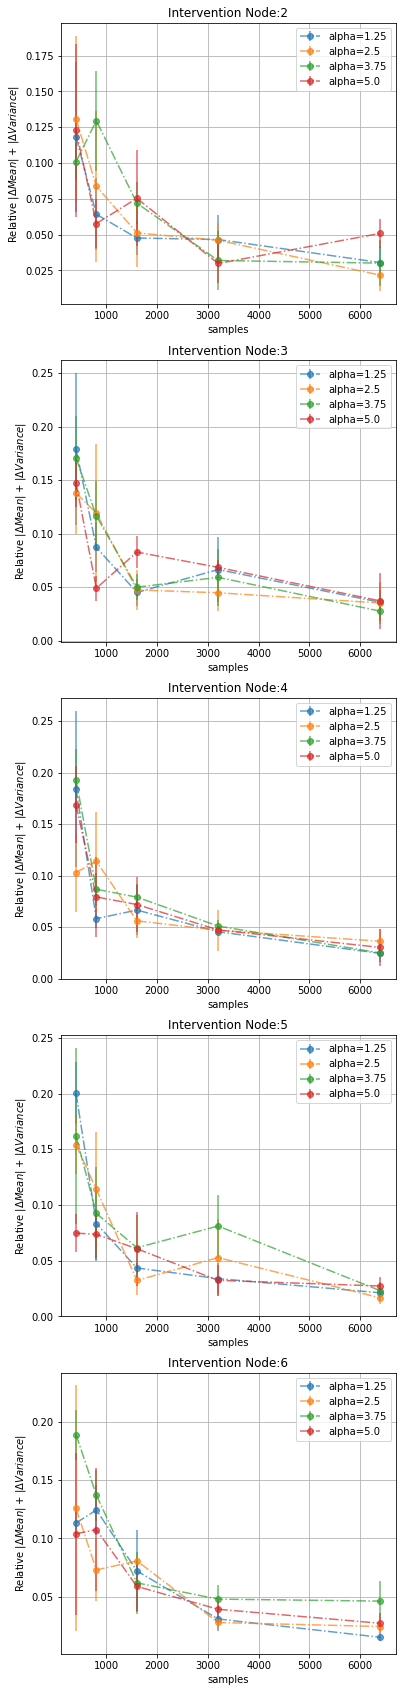

In [154]:
plt.rcParams['figure.figsize'] = [6, 6*len(intv_loc_list)]
fig,ax = plt.subplots(nrows=len(intv_loc_list),)
#Next consolidate all the runs in single place
for iidx,intv_loc in enumerate(intv_loc_list):
    for alpha in alpha_list[1:]:
        #Now collecting all the runs
        all_val_mat = []
        for ridx in run_list:
            all_val_mat.append(all_run_dict[ridx][intv_loc][alpha])

        sample_arr = np.array(sample_list)[6:]
        all_val_mat = np.array(all_val_mat)[:,6:]
        all_val_mean = np.mean(all_val_mat,axis=0)
        all_val_std = np.std(all_val_mat,axis=0)
        ax[iidx].errorbar(sample_arr,all_val_mean,all_val_std,label="alpha={}".format(alpha),ls="-.",marker="o",alpha=0.7)

    ax[iidx].set_ylabel("Relative |$\Delta Mean$| + |$\Delta Variance$|")
    ax[iidx].set_xlabel("samples")
    ax[iidx].legend()
    ax[iidx].grid()
    ax[iidx].set_title("Intervention Node:{}".format(intv_loc+1))
fig.savefig('node{}_one_intv_row_strength_var.png'.format(num_nodes), dpi=fig.dpi)